In [21]:
import random
import numpy as np  
import torch
import matplotlib.pyplot as plt
from functools import partial
from os.path import dirname, join as pjoin
import scipy
import scipy.io as sio

from accuracy_bounds.data.generator_functions import random_uni_points_in_ball
from accuracy_bounds.utils.visualizations import plot_wckersize_conv, plot_avkersize_conv, visualize_ball_3d
from accuracy_bounds.algo.kernel_size import compute_wc_kernel_size, compute_av_kernel_size
from accuracy_bounds.algo.projections import apply_forwardmodel
from accuracy_bounds.data.dataset import GeneratorDataset
from accuracy_bounds.utils.utils import set_seed

## **Example 2:** Worst Case Kernel Size over Localization Microscopy Data

### Experiment Data Directories

In [ ]:
# Get the filename for an example .mat file from the  examples/flourescencemicroscopy directory. 
# We use A2-A5 in the publication, change directory to A_3-5 for reproducing the experimental results.
data_dir1 = '/Users/Nins/Documents/CodeProjects/UPE/universal-performance-estimator/examples/flourescencemicroscopy/data_A/data_A2'

### Construct Feasible Sets for Examples of Localization Microscopy Data (K=1)

In [23]:
def load_xy_components(mat_contents):
    """ Load xyz components per example, i.e. one measurement w, from matrix.
    Args:
        -mat_contents, dictionary
    Returns: 
        -feas: xyz component feasible set for measurement of matrix."""

    x = np.array(mat_contents['x_grnd']).flatten()
    xm=np.array(mat_contents['x_mcmc']).flatten()
    x=np.concatenate((x,xm), axis=None)

    y = np.array(mat_contents['y_grnd']).flatten()
    ym=np.array(mat_contents['y_mcmc']).flatten()
    y=np.concatenate((y,ym), axis=None)

    # z is zero currently
    #z = np.array(mat_contents['z_grnd']).flatten()
    #zm=np.array(mat_contents['z_mcmc']).flatten()
    #z=np.concatenate((z,zm), axis=None)

    #create feasible set for one measurement
    f_xy= np.stack((x,y), axis=1)
    return f_xy

### Load C,h Components from Data

In [24]:
def load_ch_grnd_components(mat_contents):
    """ Load ch components per example, i.e. one measurement w, from matrix.
    Args:
        -mat_contents, dictionary
    Returns: 
        -feas: ch component feasible set from one measurement/matrix."""

    c = np.array(mat_contents['C_grnd']).flatten()
    #cm=np.array(mat_contents['C_mcmc']).flatten()
    #c=np.concatenate((c,cm), axis=None)

    h = np.array(mat_contents['h_grnd']).flatten()
    #hm=np.array(mat_contents['h_mcmc']).flatten()
    #h=np.concatenate((h,hm), axis=None)

    #create feasible set for example 001
    f_ch= np.stack((c,h), axis=1)
    return f_ch

### Load Median, Mean, Maximum A Poseriori and Maximum Likelihood Solutions from Data 

In [25]:
def load_solutions_components(mat_contents):
    """ Load median, mean, maximum a posteriori and maximum likelihood solution components per example, i.e. one measurement w, from matrix.
    Args:
        -mat_contents, dictionary
    Returns: 
        -solutions: median, mean, maximum a posteriori and maximum likelihood solution from one measurement/matrix."""
    
    # get mean solution
    x_mcmc_mean = np.array(mat_contents['x_mcmc_mean']).flatten()
    y_mcmc_mean = np.array(mat_contents['y_mcmc_mean']).flatten()
    # get solution array
    s_xy_mean = np.stack((x_mcmc_mean, y_mcmc_mean), axis=1)

    # get median solution
    x_mcmc_median = np.array(mat_contents['x_mcmc_median']).flatten()
    y_mcmc_median = np.array(mat_contents['y_mcmc_median']).flatten()
    # get solution array
    s_xy_median = np.stack((x_mcmc_median, y_mcmc_median), axis=1)

    # get map solution
    x_mcmc_map = np.array(mat_contents['x_mcmc_map']).flatten()
    y_mcmc_map = np.array(mat_contents['y_mcmc_map']).flatten()
    # get solution array
    s_xy_map = np.stack((x_mcmc_map, y_mcmc_map), axis=1)

    # get ml solution
    x_mcmc_ml = np.array(mat_contents['x_mcmc_ml']).flatten()
    y_mcmc_ml = np.array(mat_contents['y_mcmc_ml']).flatten()
    # get solution array
    s_xy_ml = np.stack((x_mcmc_ml, y_mcmc_ml), axis=1)

    # create array of different solutions for handling later on
    s_xy= [s_xy_mean,s_xy_median,s_xy_map,s_xy_ml] 

    return s_xy

### Load Ground Truth Components

In [26]:
def load_groundtruth_components(mat_contents):
    """ Load xy ground truth components per example, i.e. one measurement w, from matrix.
    Args:
        -mat_contents, dictionary
    Returns: 
        - theta_grnd: ground truth x,y,z,C,h components from one measurement/matrix."""
    
    # get grnd solutions
    x_grnd = np.array(mat_contents['x_grnd']).flatten()
    y_grnd = np.array(mat_contents['y_grnd']).flatten()
    #z_grnd = np.array(mat_contents['z_grnd']).flatten()
    #C_grnd = np.array(mat_contents['C_grnd']).flatten()
    #h_grnd = np.array(mat_contents['h_grnd']).flatten()
    # get grnd solutions array
    theta_grnd = np.stack((x_grnd, y_grnd), axis=1)

    return theta_grnd

### Get Measurement Data per Example and Visualize Measurement

In [174]:

# get list measurements, i.e. one example_00x.mat file corresponds to one measurement
# use range(1,6) for convergence tests
w_list = []
for i in range(15,16):      
  mat = pjoin(data_dir1, f"example_{str(i).zfill(3)}.mat")
  # Load the .mat file contents
  mat_contents = sio.loadmat(mat)
  # get xyxch grnd components from example i
  w = np.array(mat_contents['w']) #.flatten()
  # add xyzch grnd to list of grnd thetas
  w_list.append(w)

In [147]:
w = np.array(w)

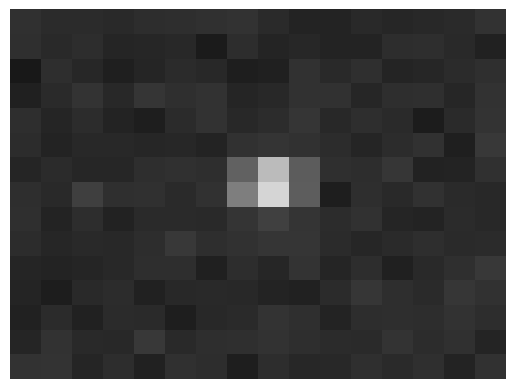

In [164]:
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt


ax = sns.heatmap(w, vmin=0, vmax=500, cmap = "gray", linewidth= 0.0, xticklabels='', yticklabels='', center = 300, cbar=False)
plt.plot(figsize=(14,12))
plt.show()

### Get List of Ground Truth Components

In [29]:
# get list of xyzcg ground truth data for each measurement, i.e. one example_00x.mat file corresponds to one measurement
# use range(1,6) for convergence tests
theta_grnd_list = []
for i in range(1,26):      
  mat = pjoin(data_dir1, f"example_{str(i).zfill(3)}.mat")
  # Load the .mat file contents
  mat_contents = sio.loadmat(mat)
  # get xyxch grnd components from example i
  theta_grnd=load_groundtruth_components(mat_contents)
  # add xyzch grnd to list of grnd thetas
  theta_grnd_list.append(theta_grnd)

### Get List of Feasible Sets per Example Measurement

In [30]:
# get list of xy feasible set data for each measurement, i.e. one example_00x.mat file corresponds to one measurement
# use range(1,6) for convergence tests
feasible_sets_list = []
for i in range(1,26):      
  mat = pjoin(data_dir1, f"example_{str(i).zfill(3)}.mat")
  # Load the .mat file contents
  mat_contents = sio.loadmat(mat)
  # get xy feasible set from example i
  f_xy=load_xy_components(mat_contents)
  # add feasible set to list of feasible sets
  feasible_sets_list.append(f_xy)


### Get List of Median, Mean, Maximum A Poseriori and Maximum Likelihood Solutions per Example Measurement

In [31]:
# get list of xy estimator (median, mean, map, ml) solution data for each measurement, i.e. one example_00x.mat file corresponds to one measurement
# use range(1,6) for convergence tests 
solutions_list = []
for i in range(1,26):      
  mat = pjoin(data_dir1, f"example_{str(i).zfill(3)}.mat")
  # Load the .mat file contents
  mat_contents = sio.loadmat(mat)
  # get xy solutions from example i
  s_xy=load_solutions_components(mat_contents)
  # add solutions to list of feasible sets
  solutions_list.append(s_xy)

### Get List of C,h Components

In [32]:
# get list of cH ground truth data for each measurement, i.e. one example_00x.mat file corresponds to one measurement
ch_list = []
for i in range(1,26):      
  mat = pjoin(data_dir1, f"example_{str(i).zfill(3)}.mat")
  # Load the .mat file contents
  mat_contents = sio.loadmat(mat)
  # get xy solutions from example i
  ch=load_ch_grnd_components(mat_contents)
  # add solutions to list of feasible sets
  ch_list.append(ch)

### MSE Loss for the Median, Mean, Maximum A Poseriori and Maximum Likelihood Solutions

In [33]:
# we compute the average l2 loss for the reconstruction (Median, Mean, Maximum A Poseriori and Maximum Likelihood Solutions) from one measurement
# given by (1/N \sum_{n=1}^N ((x_n-x_s)^2+(y_n-y_s)^2+(z_n-z_s)^2))^{1/2} for s in Median, Mean, Maximum A Poseriori and Maximum Likelihood

def rmse_solutions(feas, solutions):
    """" Compute RMSE for one measurement example from the corresponding feasible set and solution for
     the Median, Mean, Maximum A Poseriori and Maximum Likelihood solutions.
    Args:
        - feas: feasible set for one measurement.
        - solutions: array of Median, Mean, Maximum A Poseriori and Maximum Likelihood solutions.
    Returns:
        - rmse_median: rmse for the median solution.
        - rmse_mean: rmse for the mean solution.
        - rmse_map: rmse for the map solution.
        - rmse_ml: rmse for the ml solution.
    """

    num_feas = np.array(np.shape(feas))[0].astype(int)
    s_median= solutions[0].flatten()
    s_mean= solutions[1].flatten()
    s_map= solutions[2].flatten()
    s_ml = solutions[3].flatten()

    # initialize losses
    l_median = []
    l_mean = []
    l_map = []
    l_ml = []

    # compute mse losses
    for h in range(0,num_feas,1):
        err_median = np.linalg.norm(feas[h]-s_median, ord=2)
        l_median.append(err_median)

        err_mean = np.linalg.norm(feas[h]-s_mean, ord=2)
        l_mean.append(err_mean)

        err_map = np.linalg.norm(feas[h]-s_map, ord=2)
        l_map.append(err_map)

        err_ml = np.linalg.norm(feas[h]-s_ml, ord=2)
        l_ml.append(err_ml)

    rmse_median = np.power(np.divide(np.sum(np.power(l_median,2)),num_feas),0.5)   
    rmse_mean = np.power(np.divide(np.sum(np.power(l_mean,2)),num_feas),0.5) 
    rmse_map = np.power(np.divide(np.sum(np.power(l_map,2)),num_feas),0.5) 
    rmse_ml = np.power(np.divide(np.sum(np.power(l_ml,2)),num_feas),0.5) 

    return rmse_median, rmse_mean, rmse_map, rmse_ml


### Compute MSE Loss for Solutions per Example/Measurement with Feasible Sets

In [34]:
#get mse loss per example for different solutions
rmse_median_list = []
rmse_mean_list = []
rmse_map_list = []
rmse_ml_list = []


for i in range(0,25):
    rmse = rmse_solutions(feasible_sets_list[i],solutions_list[i])
    rmse_median_list.append(rmse[0])
    rmse_mean_list.append(rmse[1])
    rmse_map_list.append(rmse[2])
    rmse_ml_list.append(rmse[3])
    
rmse_median =np.array(rmse_median_list)
rmse_median_nm = np.multiply(rmse_median, 1000)

rmse_mean =np.array(rmse_mean_list)
rmse_mean_nm = np.multiply(rmse_mean, 1000)

rmse_map =np.array(rmse_map_list)
rmse_map_nm = np.multiply(rmse_map, 1000)

rmse_ml =np.array(rmse_ml_list)
rmse_ml_nm = np.multiply(rmse_ml, 1000)


print(rmse_median_nm)
print(rmse_mean_nm)
print(rmse_map_nm)
print(rmse_ml_nm)

rmse_median_nm_plot = ','.join(str(x) for x in rmse_median_nm)
rmse_mean_nm_plot = ','.join(str(x) for x in rmse_mean_nm)
rmse_map_nm_plot = ','.join(str(x) for x in rmse_map_nm)
rmse_ml_nm_plot = ','.join(str(x) for x in rmse_ml_nm)


[2.63079091 2.66881099 2.64054905 2.61220627 2.56388986 2.67899207
 2.6279378  2.52830796 2.73907847 2.72590989 2.65156106 2.72171309
 2.73731491 2.65530811 2.52983318 2.5272885  2.67165626 2.49258264
 2.59810831 2.74189589 2.64035931 2.5757119  2.5369481  2.60610066
 2.72082732]
[2.63221993 2.6689812  2.64187838 2.61224804 2.56407893 2.68050442
 2.62852516 2.52850038 2.73942816 2.72618616 2.65178979 2.72173614
 2.73815082 2.65642033 2.53042781 2.52759264 2.6724108  2.49260046
 2.59933094 2.74204224 2.64059474 2.57609194 2.53701313 2.6061355
 2.72095554]
[5.54520473 2.68167594 3.79487885 2.71906284 3.06974014 2.70032038
 3.61437142 3.9486823  3.51328013 4.50511135 4.7958161  2.93468775
 3.01179073 4.62494128 2.82535547 2.6739764  3.03565825 2.58950381
 3.60438158 4.21763952 3.52647672 3.44800173 2.80983954 4.2567003
 3.74352077]
[4.08039721 3.08580604 4.49231853 3.22471698 4.5744138  3.31175242
 4.5935325  3.60363968 2.86128758 4.38997626 2.96784439 2.80582292
 4.10407851 2.97641839 2.

### MSE Loss for the Median, Mean, Maximum A Poseriori and Maximum Likelihood Solutions againt the Ground Truth

In [35]:
# we compute the average l2 loss for the reconstruction (Median, Mean, Maximum A Poseriori and Maximum Likelihood Solutions) from one measurement
# given by (1/N \sum_{n=1}^N ((x_n-x_s)^2+(y_n-y_s)^2+(z_n-z_s)^2))^{1/2} for s in Median, Mean, Maximum A Poseriori and Maximum Likelihood

def rmse_solutions_grnd(theta_grnd, solutions):
    """" Compute RMSE for one measurement example from the corresponding ground truth solution and solution for
     the Median, Mean, Maximum A Poseriori and Maximum Likelihood solutions.
    Args:
        - theta_grnd: ground truth solution for one measurement.
        - solutions: array of Median, Mean, Maximum A Poseriori and Maximum Likelihood solutions.
    Returns:
        - rmse_median: rmse for the median solution.
        - rmse_mean: rmse for the mean solution.
        - rmse_map: rmse for the map solution.
        - rmse_ml: rmse for the ml solution.
    """

    s_median= solutions[0].flatten()
    s_mean= solutions[1].flatten()
    s_map= solutions[2].flatten()
    s_ml = solutions[3].flatten()

    # initialize losses
    l_median = []
    l_mean = []
    l_map = []
    l_ml = []

    # compute mse losses
    err_median = np.linalg.norm(theta_grnd[0:1]-s_median, ord=2)
    l_median.append(err_median)

    err_mean = np.linalg.norm(theta_grnd[0:1]-s_mean, ord=2)
    l_mean.append(err_mean)

    err_map = np.linalg.norm(theta_grnd[0:1]-s_map, ord=2)
    l_map.append(err_map)

    err_ml = np.linalg.norm(theta_grnd[0:1]-s_ml, ord=2)
    l_ml.append(err_ml)

    rmse_median = l_median  
    rmse_mean = l_mean
    rmse_map = l_map
    rmse_ml = l_ml 

    return rmse_median, rmse_mean, rmse_map, rmse_ml


### Compute MSE Loss for Solutions per Example/Measurement against the Ground Truth

In [36]:
#get mse loss per example for different solutions
rmse_median_list_grnd = []
rmse_mean_list_grnd = []
rmse_map_list_grnd = []
rmse_ml_list_grnd = []


for i in range(0,25):
    rmse = rmse_solutions(theta_grnd_list[i],solutions_list[i])
    rmse_median_list_grnd.append(rmse[0])
    rmse_mean_list_grnd.append(rmse[1])
    rmse_map_list_grnd.append(rmse[2])
    rmse_ml_list_grnd.append(rmse[3])
    
rmse_median_grnd =np.array(rmse_median_list_grnd)
rmse_median_grnd_nm = np.multiply(rmse_median, 1000)

rmse_mean_grnd =np.array(rmse_mean_list_grnd)
rmse_mean_grnd_nm = np.multiply(rmse_mean_grnd, 1000)

rmse_map_grnd =np.array(rmse_map_list_grnd)
rmse_map_grnd_nm = np.multiply(rmse_map, 1000)

rmse_ml_grnd =np.array(rmse_ml_list_grnd)
rmse_ml_grnd_nm = np.multiply(rmse_ml_grnd, 1000)


print(rmse_median_grnd_nm)
print(rmse_mean_grnd_nm)
print(rmse_map_grnd_nm)
print(rmse_ml_grnd_nm)

[2.63079091 2.66881099 2.64054905 2.61220627 2.56388986 2.67899207
 2.6279378  2.52830796 2.73907847 2.72590989 2.65156106 2.72171309
 2.73731491 2.65530811 2.52983318 2.5272885  2.67165626 2.49258264
 2.59810831 2.74189589 2.64035931 2.5757119  2.5369481  2.60610066
 2.72082732]
[0.63508803 1.78005613 2.94596069 2.514966   1.94113406 2.25710729
 1.4245045  3.45737805 5.53396211 0.75808994 1.43459153 1.583559
 1.19675627 2.20210304 3.50077719 3.46429003 3.23004023 1.59587139
 2.00085707 1.89879642 1.85507465 5.28577428 1.47102973 6.57127587
 2.76814632]
[5.54520473 2.68167594 3.79487885 2.71906284 3.06974014 2.70032038
 3.61437142 3.9486823  3.51328013 4.50511135 4.7958161  2.93468775
 3.01179073 4.62494128 2.82535547 2.6739764  3.03565825 2.58950381
 3.60438158 4.21763952 3.52647672 3.44800173 2.80983954 4.2567003
 3.74352077]
[ 2.55904223  3.27120494  1.36358068  0.63389691  5.32579428  2.18011816
  4.66036048  5.51269465  5.68828589  2.98440415  0.81436221  2.09550895
  2.06693047  

In [37]:
# MSE over the whole dataset with 25*1501 data points for the A_1-A_5 experiments

rmse_median_nm_av = np.power(np.divide(np.sum(np.power(rmse_median_nm,2)),25),0.5)
rmse_mean_nm_av = np.power(np.divide(np.sum(np.power(rmse_mean_nm,2)),25),0.5)
rmse_map_nm_av = np.power(np.divide(np.sum(np.power(rmse_map_nm,2)),25),0.5)
rmse_ml_nm_av = np.power(np.divide(np.sum(np.power(rmse_ml_nm,2)),25),0.5)

print(rmse_median_nm_av)
print(rmse_mean_nm_av)
print(rmse_map_nm_av)
print(rmse_ml_nm_av)

2.6339819654492693
2.6344700440113415
3.611123112574978
3.7186112686835946


In [38]:
# MSE for 25 data points for the A_1-A_5 experiments

rmse_median_grnd_nm_av = np.power(np.divide(np.sum(np.power(rmse_median_grnd_nm,2)),25),0.5)
rmse_mean_grnd_nm_av = np.power(np.divide(np.sum(np.power(rmse_mean_grnd_nm,2)),25),0.5)
rmse_map_grnd_nm_av = np.power(np.divide(np.sum(np.power(rmse_map_grnd_nm,2)),25),0.5)
rmse_ml_grnd_nm_av = np.power(np.divide(np.sum(np.power(rmse_ml_grnd_nm,2)),25),0.5)

print(rmse_median_grnd_nm_av)
print(rmse_mean_grnd_nm_av)
print(rmse_map_grnd_nm_av)
print(rmse_ml_grnd_nm_av)

2.6339819654492693
2.916861515163071
3.611123112574978
4.248342447488302


### **Example Computations:** Kernel Sizes for Flouresence Microscopy Data

In [39]:
def compute_worstcase_average_kersize_one_feas(feas):
    """" Compute average and worst case kernel size with the l2 norm from one feasible set.
    Args:
        -feas: array of elements in one feasible set
    Returns: 
        - average_kersize_y: average diameter of feas (feasible set)
        - num_feas: number of elements in feas (feasible set)
        - max_diam_Fy: largest diameter of feas (feasible set) or also worst case kernel size
    """
    max_diam_Fy = 0
    diameter_mean_y = 0
    diam_y = []
    num_feas = np.array(np.shape(feas))[0].astype(int)
    # compute diameters
    for h in range(0,num_feas,1):
        for j in range(0,h+1,1):
            #compute vectors in null space of F and their norm
            dist_ns = feas[h]-feas[j]
            diameter= np.linalg.norm(dist_ns, ord = 2)

            #add to diam_y 
            diam_y.append(diameter)

            #get ascending diams
            if diameter > max_diam_Fy:
                max_diam_Fy = diameter
                            
    # get mean over diams, with factor 2 due to symmetry of the norm of the compute vectors in null space of F (norm(x-z)=norm(z-x))
    # and divided by num_feas^2 ad we have that many terms
    if num_feas > 0:      
        # compute 2 times sum over diams to the power p divided by num_feas^2
        average_kersize_y = 2*np.divide(np.sum(np.power(diam_y,2)), np.power(num_feas,2))
        average_kersize_y = np.power(average_kersize_y, 0.5)
    elif num_feas==0:
        average_kersize_y = 0  

    return average_kersize_y, num_feas, max_diam_Fy
    

### Compute Worst Case and Average Kernel Size per Example with on one Feasible Set

In [40]:
#get 2 times sqrt of average kernel size per sample
average_kersize = []
diameters = []

for i in range(0,25):
    #print(compute_wc_av_diams_feas(feasible_sets_list[i]))
    average_kersize.append(compute_worstcase_average_kersize_one_feas(feasible_sets_list[i])[0])
    diameters.append(compute_worstcase_average_kersize_one_feas(feasible_sets_list[i])[2])
    
diameters=np.array(diameters)
diameters= np.multiply(diameters, 1000)
average_kersize=np.array(average_kersize)
kernel_size_nm= np.multiply(average_kersize, 1000)
kernel_size_nm_half = np.divide(kernel_size_nm, 2)

kernel_size_nm_half_plot = ','.join(str(x) for x in kernel_size_nm_half)

print(kernel_size_nm_half)
print(diameters)

KeyboardInterrupt: 

### Get Average Kernel Size for K=25 Examples and K Feasible Sets with 1501 samples each

In [ ]:
#get 2 times sqrt of average kernel size per sample
average_kersize_full = []

for i in range(0,25):
    #print(compute_wc_av_diams_feas(feasible_sets_list[i]))
    average_kersize_full.append(compute_worstcase_average_kersize_one_feas(feasible_sets_list[i])[0])

average_kersize_full=np.array(average_kersize_full)
average_kersize_full_nm= np.multiply(average_kersize_full, 1000)
average_kersize_full_nm = np.power(average_kersize_full_nm,2)
average_kersize_full_nm = np.power(np.mean(average_kersize_full_nm),0.5)
print(average_kersize_full_nm)

3.725011997287478


### Make Table Content with average and worst-case kernel size per example

In [ ]:
#def make_latex_table(average_ker,wc_ker):
for i in range(len(diameters)):
    x =  f"example {str(i+1).zfill(3)} &"+str(round(kernel_size_nm[i],4))+"nm &"+str(round(diameters[i],4))+"nm \\"+"\\"
    print(x)


example 001 &3.7205nm &12.2895nm \\
example 002 &3.7743nm &14.7716nm \\
example 003 &3.7343nm &12.9538nm \\
example 004 &3.6942nm &13.2775nm \\
example 005 &3.6259nm &13.4337nm \\
example 006 &3.7887nm &13.5854nm \\
example 007 &3.7165nm &13.0135nm \\
example 008 &3.5756nm &12.9801nm \\
example 009 &3.8736nm &13.4907nm \\
example 010 &3.855nm &13.1586nm \\
example 011 &3.7499nm &13.9205nm \\
example 012 &3.8491nm &15.0286nm \\
example 013 &3.8711nm &14.6676nm \\
example 014 &3.7552nm &13.7576nm \\
example 015 &3.5777nm &13.7086nm \\
example 016 &3.5741nm &12.5123nm \\
example 017 &3.7783nm &13.4247nm \\
example 018 &3.525nm &12.5958nm \\
example 019 &3.6743nm &13.2395nm \\
example 020 &3.8776nm &13.4042nm \\
example 021 &3.734nm &15.0972nm \\
example 022 &3.6426nm &14.0748nm \\
example 023 &3.5878nm &13.4931nm \\
example 024 &3.6856nm &12.5621nm \\
example 025 &3.8478nm &15.7797nm \\


### Visualize feasible sets

In [ ]:
# get three dimensional positions by adding z-component to xy components
new_list_of_arrays = []
k=len(feasible_sets_list)
for i in range(k):
    for j in range(81):
        x=np.multiply(np.array(feasible_sets_list)[i,j],1000)
        new_list_of_arrays.append(np.append(x,0))

# get positions in nm
#np.multiply(new_list_of_arrays, 1000)
print(new_list_of_arrays)


[array([ 65.93920015, -47.46818888,   0.        ]), array([ 60.91682254, -45.76232508,   0.        ]), array([ 64.44372228, -48.0308511 ,   0.        ]), array([ 66.00559267, -46.89120991,   0.        ]), array([ 66.64151753, -48.45048398,   0.        ]), array([ 68.74583714, -45.5881016 ,   0.        ]), array([ 66.0917989 , -47.27405953,   0.        ]), array([ 65.57475715, -49.72005445,   0.        ]), array([ 66.80852646, -45.81256206,   0.        ]), array([ 66.42235784, -44.46608564,   0.        ]), array([ 64.68370614, -44.6904826 ,   0.        ]), array([ 64.47852761, -46.59461626,   0.        ]), array([ 68.10738824, -48.03797916,   0.        ]), array([ 69.57903753, -44.09229057,   0.        ]), array([ 68.61308144, -43.65342854,   0.        ]), array([ 68.47606099, -48.28056041,   0.        ]), array([ 62.16756141, -46.91475512,   0.        ]), array([ 63.97441628, -47.78260796,   0.        ]), array([ 63.65243801, -47.91406236,   0.        ]), array([ 64.64940183, -48.68791

### Plot feasible sets

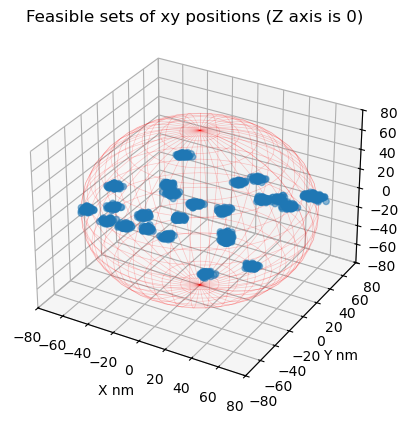

In [ ]:
# set radius and center in nm
radius = 80
center = [0,0,0]
# use new 3d data
new_list_of_arrays = np.array(new_list_of_arrays)

# plot feasible sets
visualize_ball_3d(points=new_list_of_arrays, radius=radius, center=center, title="Feasible sets of xy positions (Z axis is 0)", x_axis="X nm", y_axis="Y nm")

### Convergence study: Compute average kernel size per example for different numbers of samples in the feasible sets

In [ ]:
# get list of xy feasible set data for each measurement, i.e. one example_00x.mat file corresponds to one measurement
# use range(1,6) for convergence tests
feasible_sets_list = []
for i in range(1,6):      
  mat = pjoin(data_dir1, f"example_{str(i).zfill(3)}.mat")
  # Load the .mat file contents
  mat_contents = sio.loadmat(mat)
  # get xy feasible set from example i
  f_xy=load_xy_components(mat_contents)
  # add feasible set to list of feasible sets
  feasible_sets_list.append(f_xy)

In [ ]:
# test convergence over number of points in feasible sets for first example
#get 2 times sqrt of average kernel size per sample
n = len(feasible_sets_list[0])
av_diameters = []

for i in range(0,n, 1):
    #print(compute_wc_av_diams_feas(feasible_sets_list[i]))
    av_diameters.append(compute_worstcase_average_kersize_one_feas(feasible_sets_list[0][:i])[0])
    
av_diameters=np.array(av_diameters)
kernel_size= av_diameters
kernel_size_nm= np.multiply(kernel_size, 1000)

print(kernel_size_nm)

#### Costum Plot for Convergence over elements in feasible sets

In [ ]:
def plot_avkersize_conv(av_kersize, av_kersizes, ker_size, max_k):

    # Plot results
    x_axis = np.arange(1, max_k+1,1)
    y_axis = np.array(av_kersizes)
    plt.plot(x_axis, y_axis)
    plt.axhline(ker_size, color='r')
    plt.ylim(0, ker_size + 0.3 * ker_size)
    plt.grid()
    plt.xlabel("Number of samples in feasible set")
    plt.ylabel("Average kernel size nm")
    plt.title("Number of Samples vs Average Kernel Size")
    plt.show()

    #max_diameter_total = max(max_diameters)
    print(f"Total Max Kernel Size: {av_kersize}")
    print(f"Analytical Kernel Size: {ker_size}")
    rel_error = (av_kersize - ker_size) / ker_size
    print(f"Relative Error: {rel_error}")

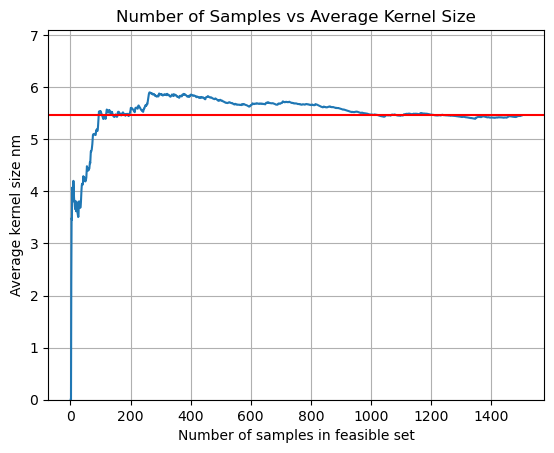

Total Max Kernel Size: 5.459270458589457
Analytical Kernel Size: 5.459270458589457
Relative Error: 0.0


In [ ]:
plot_avkersize_conv(kernel_size_nm[-1], kernel_size_nm, kernel_size_nm[-1], 1501)

## Make pandas dataframe for Pgfplots plot of average kernel sizes vs rmse of estimators/approximate inverse maps

In [ ]:
import pandas as pd

In [ ]:
# average and worst case kernel sizes for each example from S1 and S2 withoutnonconvergence datasets
data = {'S1avks': [2.81984274, 2.52456285, 2.93999364, 2.87908577, 2.48313559, 2.52985472, 2.63549547, 2.86734038, 2.79981648, 2.72337587, 2.69917413, 2.85854827, 2.90281476, 2.53415562, 2.45653896, 2.76292702, 2.9642318,  2.50742732, 2.33954273, 2.85029076, 2.66870454, 2.48782874, 2.33447335, 3.10600412, 2.36194411],
'S1wcks': [7.88910328, 7.24699002, 7.5747996,  9.1317229,  6.67577104, 6.29607315, 6.96026567, 8.71377922, 6.60072404, 7.27140664, 7.4406676,  7.6568002, 8.09088206, 7.2105533,  7.55455232, 7.20595675, 7.88631337, 6.44527337, 7.13049569, 7.0552734,  6.42944878, 7.73534217, 6.45264071, 9.1462696, 6.36679565],
'S2avks': [14.87453693,   13.05211968,   15.92466207,   16.52877579,   16.77368654, 1164.19131272,   14.63142384 ,  16.6516651,    17.3112466 ,   14.97206916, 17.18111329 ,  16.02625365 ,  17.53845882,   14.9737023 ,   17.23682357, 12.40655529,   16.85611238,  203.8826256,    15.60969986,   16.46718978, 14.19060641,   15.44779899,   15.11982164,   15.59587096,   15.03524897],
'S2wcks': [35.89054489,   35.58559742 ,  48.08258651,   45.27438677,   53.29260412, 2731.90629477,   35.4099467,    49.11512198,   42.04715567,   45.12667386, 46.41530173,   45.65078922,   47.47105893,   41.32577671,   47.76656845, 32.70560223,   42.9580566,  1243.25456402,   42.11163875,   42.68207379, 39.26977284 ,  42.74113241,   47.44794364 ,  46.49679218,   43.30887707]}
df = pd.DataFrame(data)

# Transpose the DataFrame using .transpose()
df_transposed = df.transpose()

In [ ]:

print(df)

      S1avks    S1wcks       S2avks       S2wcks
0   2.819843  7.889103    14.874537    35.890545
1   2.524563  7.246990    13.052120    35.585597
2   2.939994  7.574800    15.924662    48.082587
3   2.879086  9.131723    16.528776    45.274387
4   2.483136  6.675771    16.773687    53.292604
5   2.529855  6.296073  1164.191313  2731.906295
6   2.635495  6.960266    14.631424    35.409947
7   2.867340  8.713779    16.651665    49.115122
8   2.799816  6.600724    17.311247    42.047156
9   2.723376  7.271407    14.972069    45.126674
10  2.699174  7.440668    17.181113    46.415302
11  2.858548  7.656800    16.026254    45.650789
12  2.902815  8.090882    17.538459    47.471059
13  2.534156  7.210553    14.973702    41.325777
14  2.456539  7.554552    17.236824    47.766568
15  2.762927  7.205957    12.406555    32.705602
16  2.964232  7.886313    16.856112    42.958057
17  2.507427  6.445273   203.882626  1243.254564
18  2.339543  7.130496    15.609700    42.111639
19  2.850291  7.0552

## More Dataframe Creation for A2-A5 Experiments (Used in Publication)

In [ ]:
# get arrays with commas for data frame individually if we have S1 or S2 data
print([rmse_median_nm_plot]) 
print([rmse_mean_nm_plot])
print([rmse_map_nm_plot])
print([rmse_ml_nm_plot])
print([kernel_size_nm_half_plot])

['3.8590570836166513,4.284974717785591,3.84064241513046,4.028225392285152,3.990775494331482,3.988187555416636,4.027643905393978,3.883882660893761,3.7024469080558693,4.12573882518952,4.071893381289408,4.042247313852237,4.153107619381857,3.728851103900473,3.7212802707249484,4.182137359177292,4.079869889925427,3.786239954932107,4.2702937285215885,3.848749540417155,3.7759439757089535,3.9116062111422285,3.8768395485202234,3.9644378809459093,3.8902233954734142']
['3.8594505467679996,4.285021031236457,3.8407192423751706,4.028306859986138,3.991414426897321,3.988722743265772,4.030836398406201,3.88397027795049,3.702693875363092,4.125995166418082,4.0719857958921635,4.042697874342313,4.153427583349246,3.7301950572287357,3.7214687938529063,4.1826437610398495,4.0816759051002975,3.7864529214451346,4.270644416682328,3.8487721313627845,3.7772334982062423,3.9131191968938386,3.8784446474673597,3.9645319326892707,3.891133003617543']
['4.987864725048296,4.957929578816198,4.551524021435011,6.112926325221281

In [ ]:
# average and worst case kernel sizes for each example from S1 and S2 withoutnonconvergence datasets
data_scatterS1S2 = {
#'A5havks': [8.057045913447226,8.40687904236339,9.034266613763458,7.598880751796441,8.975958842177276,8.339389204321911,8.108764718409574,9.164223594897814,8.753202279616875,7.826873245593471,8.166242492061926,7.489273579862762,7.649263631454438,8.33413727254304,8.088141528556532,8.438768491052576,7.7537791096836335,7.928207455936363,8.585371789124926,7.133919243622605,8.069413073688386,7.9460972738584035,8.378057598754914,8.548845358452194,8.497294181329233],
#'A3havks': [2.7287654110783137,3.029934050163641,2.7157428657583758,2.848385250399498,2.8219037025711065,2.8200742194681085,2.8479739382359703,2.7463193699992137,2.6180223119167967,2.9173377755685297,2.8792620991550177,2.8583003248921766,2.936689844934549,2.636694316125735,2.6313424879629213,2.9572173642108432,2.8849034956418205,2.6772748441821568,3.0195532748629663,2.721476717080584,2.6699946282224762,2.7659227312874552,2.741339167963909,2.8032807027686704,2.750803238209271],
'A2havks': [1.4099213710029532,1.262281423517352,1.4699968195661053,1.439542886206111,1.2415677936973635,1.264927358766574,1.317747734951377,1.4336701889588468,1.3999082407449308,1.361687932721503,1.3495870648991881,1.4292741366436168,1.4514073807950216,1.2670778121401944,1.2282694804305345,1.3814635123951313,1.4821158986291822,1.253713659078564,1.169771364066536,1.425145378724291,1.3343522688834522,1.2439143695550081,1.1672366726253034,1.5530020604063055,1.180972056061683],
#'A4havks': [4.479529587897791,4.586010496866356,4.107806694010653,4.350192587705725,4.0288947209942245,4.600962593724276,4.489064555072496,4.714386085640461,4.111736238027606,4.576763268921012,4.718010873337278,4.259819110908843,4.544628571156035,4.4560746182100806,4.460731173673399,4.219542471214839,4.627207233695271,4.3201898629548126,4.677762114099633,4.222610016514406,4.6675867734339285,4.376899467922647,4.309182041316666,4.253022593930642,4.9678700725095295],
#'A5median': [11.39438744882254,11.8891235925437,12.776386076342948,10.746440277150858,12.693924576008156,11.793680616337092,11.467528351756782,12.960171074243544,12.37889793354795,11.06887329857802,11.548820708579102,10.5914373346797,10.817704091733868,11.786250882958326,11.438360342672455,11.934221120620535,10.965501477231165,11.212180183763497,12.141552582287456,10.088886524147272,11.411873443799516,11.237486334007711,11.848364242405246,12.089894594991305,12.01699009189337],
# 'A5mean' : [11.402657918988204,11.892111843674478,12.780899316455837,10.746629445088088,12.694528202498137,11.795353771975227,11.467711059187463,12.960414039444753,12.379135034465088,11.07633999154914,11.555058844800264,10.5924967258547,10.828108080313863,11.791145049960672,11.438895167170859,11.938762548381458,10.965896564639506,11.214833851795541,12.147812364111724,10.091162804278525,11.415062951276434,11.23847759069597,11.848393289069632,12.090586002632683,12.01774105265125],
# 'A5map' : [24.747876092593803,13.669056595935794,14.172486161762047,16.16537058949731,14.990910506077036,17.381170640976936,12.478985441479983,25.720592606302887,13.317880693188961,11.117802766807495,12.59572338271172,12.010073968240167,12.608139904916682,16.907627791996187,16.65596758489805,31.43441850957747,13.375611016774506,11.782283355942491,14.44353118616718,14.811504469517695,17.414417663444077,11.478945099310915,18.963267371685664,16.38744845274823,20.76177855337587],
# 'A5ml' : [15.737762491118048,17.107239533554583,22.057356347722916,15.979494254495107,13.153956026221124,12.887187849120552,22.07478726787507,23.180080993036736,13.037006091085525,26.424774067248798,14.84929440429328,13.612145314636097,14.395349760557378,13.710388967866686,20.069373277693494,13.521588364472835,15.767251528065362,13.635500406135767,15.074651075874973,12.006529904661683,15.304982262847469,14.18550642693157,12.865200095246271,18.9493292346307,16.87556171327199],
#'A4median': [6.335012081025821,6.485598772922755,5.809316796789504,6.1521020572443454,5.697718322340495,6.506744174598895,6.348496291676941,6.667148995636023,5.814873889198743,6.472523585729082,6.672279741641309,6.024294441173746,6.42707536950974,6.30184167621806,6.308426692699514,5.967334221447212,6.543860474915453,6.109671345717128,6.615360926198156,5.971674764012101,6.600968297419572,6.189874398737195,6.094104598197182,6.014684460225012,7.025631039925976],
#'A4mean': [6.335915338665453,6.488510602933088,5.813311732596734,6.1521804769457615,5.698185699981154,6.50682895029621,6.349156927810307,6.670419444495425,5.8167639255784085,6.47272727079339,6.675730445802523,6.028870244292326,6.427688877521255,6.3018557483369,6.310698598866938,5.972677602932963,6.545124745370091,6.110246490280484,6.617144933272393,5.972093841042135,6.605585586811386,6.190032704641378,6.094650552443971,6.0153843171308,7.026012690136724],
#'A4map': [9.330971401450979,12.77665202834961,7.234583679009828,9.31918037458805,7.217898176986898,7.385255042697905,7.173123568178663,9.156676839921952,8.401471651429176,7.626792465599259,11.157310763561389,6.7677675824386085,7.065386565496249,10.609736414231525,8.609678798011334,10.361549253636612,12.49136298283651,10.182248946687881,9.089064071358004,6.344238003363441,7.925202857820611,11.81537636742897,8.71585238551263,13.029051142706658,8.097671460921548],
#'A4ml': [8.020134501235509,7.704862057504628,7.1884758661421255,7.690473567577779,10.294590388721684,7.727725342431873,7.262242365931291,7.675810982298959,6.4171261610554575,11.360378168887324,7.8907216647889165,6.5548343962413425,6.787838101635505,6.688487668504379,7.303680975639497,7.338185891378035,6.984970914876885,6.396881994681729,8.41039648898047,7.791288839089929,6.917922929533576,6.315966857321974,12.62081058520618,9.528367688005929,10.846077363696986],
#'A3median': [3.8590570836166513,4.284974717785591,3.84064241513046,4.028225392285152,3.990775494331482,3.988187555416636,4.027643905393978,3.883882660893761,3.7024469080558693,4.12573882518952,4.071893381289408,4.042247313852237,4.153107619381857,3.728851103900473,3.7212802707249484,4.182137359177292,4.079869889925427,3.786239954932107,4.2702937285215885,3.848749540417155,3.7759439757089535,3.9116062111422285,3.8768395485202234,3.9644378809459093,3.8902233954734142],
#'A3mean': [3.8594505467679996,4.285021031236457,3.8407192423751706,4.028306859986138,3.991414426897321,3.988722743265772,4.030836398406201,3.88397027795049,3.702693875363092,4.125995166418082,4.0719857958921635,4.042697874342313,4.153427583349246,3.7301950572287357,3.7214687938529063,4.1826437610398495,4.0816759051002975,3.7864529214451346,4.270644416682328,3.8487721313627845,3.7772334982062423,3.9131191968938386,3.8784446474673597,3.9645319326892707,3.891133003617543],
#'A3map': [4.987864725048296,4.957929578816198,4.551524021435011,6.112926325221281,6.795316339434102,4.052720413744278,4.618461016713047,4.79660441498859,3.7927455666474503,4.696337563096464,6.124748349453985,4.731517740891947,5.866557515719927,3.9745566385594264,3.8934853993762717,7.0921714984521875,4.321750351099938,4.938793880825135,4.677402271986814,6.2020921203032895,4.722587209486392,4.491861696075376,4.9249229361591,5.687281888411644,4.309243839901416],
#'A3ml': [7.559779183417369,4.367353411089907,5.429928452140566,5.893497193708091,7.202550095821619,4.925721291157279,4.9211545721834336,5.634319806801766,3.8827006953902456,5.071360571142223,9.290751595573457,4.174633929331646,7.853579945734156,4.22521770049449,3.8510717256235236,7.910930752024227,5.22292272843495,5.489237267905888,5.4311713810674425,4.224714818582046,7.094361897827538,5.425105768345626,6.282712103969356,5.335999939620419,4.233903203142197],
#'A2median': [1.9939946131388577,1.7852247118343414,2.078974545983495,2.035835237743719,1.7561592850769236,1.788945890460629,1.8637775493620137,2.0277834376766894,1.979812659811609,1.9257466742039937,1.9088020926384297,2.0213325363504806,2.0527592416618137,1.7920376029781926,1.7373225294375783,1.9538544627807244,2.0961142274886644,1.773021658904012,1.6545437604454942,2.0155662294328898,1.887063126899235,1.759428672407214,1.6509747314161858,2.1962771078387378,1.6703061297045048],
#'A2mean': [2.0127273203842915,1.795208747010907,2.089623973463865,2.0406330468362763,1.7566192012220136,1.7894384013970965,1.8817228654408025,2.0342032526047373,1.9815090099526327,1.9275474084790838,1.9086352268349822,2.0294049804551073,2.0764551946980196,1.8043343120485793,1.7402088916780993,1.9659224363097507,2.101450257062645,1.7797306961756891,1.6568259901173863,2.0317881429145,1.8916177446815674,1.7597708506648992,1.6609037110210059,2.1995028651333337,1.6732038785065164],
#'A2map': [2.0266940148652184,2.3923222651070444,3.780477353424634,2.080749077676116,1.7640339373107632,2.636431759562715,3.073294571270713,2.101902787180519,2.5211889781123276,3.1986654477308645,1.9238101537449164,2.3002381668304377,2.3712674613479865,2.1603314089503964,1.8909172607959168,3.334087183411852,2.6270809320267645,1.844167948522545,1.9532650504141624,2.9834259915443,2.145176181393482,2.0735534788352754,2.1274540443865155,2.3420697826788563,1.8925058417976428],
'A2ml': [2.2736437882420355,2.27168149278541,2.4659221211057036,2.304377147452489,2.468190289540851,3.090155587343834,2.870934290932044,2.0881336784327957,2.622066597867837,2.1921432099241875,2.862812574585919,3.0281162446214225,2.3545666607764213,3.3717234739312567,2.0861042736816926,3.1773050043433995,2.6254662993509235,2.488292637327004,1.8816316230806085,3.046926566625236,2.698440151185579,2.282891571851356,1.7905711502227648,3.272533976873022,1.6858290821079904],
#'label' : ['A3','A3','A3','A3','A3', 'A3','A3','A3','A3','A3','A3','A3','A3','A3','A3','A3','A3','A3','A3','A3','A3','A3','A3','A3','A3'],
'label' : ['A2','A2','A2','A2','A2', 'A2','A2','A2','A2','A2', 'A2','A2','A2','A2','A2', 'A2','A2','A2','A2','A2','A2','A2','A2','A2','A2' ],
#'label' : ['A4','A4','A4','A4','A4','A4','A4','A4','A4','A4','A4','A4','A4','A4','A4','A4','A4','A4','A4','A4','A4','A4','A4','A4','A4'],
#'label' : ['A5','A5','A5','A5', 'A5', 'A5','A5','A5','A5', 'A5', 'A5','A5','A5','A5', 'A5', 'A5','A5','A5','A5', 'A5', 'A5','A5','A5','A5', 'A5']
 }
df = pd.DataFrame(data_scatterS1S2)
# Display DataFrame without the index
display(df.style.hide(axis='index'))
print(df)

A2havks,A2ml,label
1.409921,2.273644,A2
1.262281,2.271681,A2
1.469997,2.465922,A2
1.439543,2.304377,A2
1.241568,2.468190,A2
1.264927,3.090156,A2
1.317748,2.870934,A2
1.433670,2.088134,A2
1.399908,2.622067,A2
1.361688,2.192143,A2


     A2havks      A2ml label
0   1.409921  2.273644    A2
1   1.262281  2.271681    A2
2   1.469997  2.465922    A2
3   1.439543  2.304377    A2
4   1.241568  2.468190    A2
5   1.264927  3.090156    A2
6   1.317748  2.870934    A2
7   1.433670  2.088134    A2
8   1.399908  2.622067    A2
9   1.361688  2.192143    A2
10  1.349587  2.862813    A2
11  1.429274  3.028116    A2
12  1.451407  2.354567    A2
13  1.267078  3.371723    A2
14  1.228269  2.086104    A2
15  1.381464  3.177305    A2
16  1.482116  2.625466    A2
17  1.253714  2.488293    A2
18  1.169771  1.881632    A2
19  1.425145  3.046927    A2
20  1.334352  2.698440    A2
21  1.243914  2.282892    A2
22  1.167237  1.790571    A2
23  1.553002  3.272534    A2
24  1.180972  1.685829    A2


## Hacky Stuff For Tables with MSE Loss with Feasible Sets vs. Ground Truth

### Compute Average MSE Loss over 25 Examples